# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [61]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

<ipython-input-61-15472fb06c30>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [11]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [14]:
logins['count']=1
logins.index = logins['login_time']
logins.drop('login_time',axis=1,inplace=True)
logins.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


In [16]:
logins_count = logins.resample('15min').sum()

In [17]:
logins.describe()

,count
count,93142.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


<Axes: xlabel='login_time'>

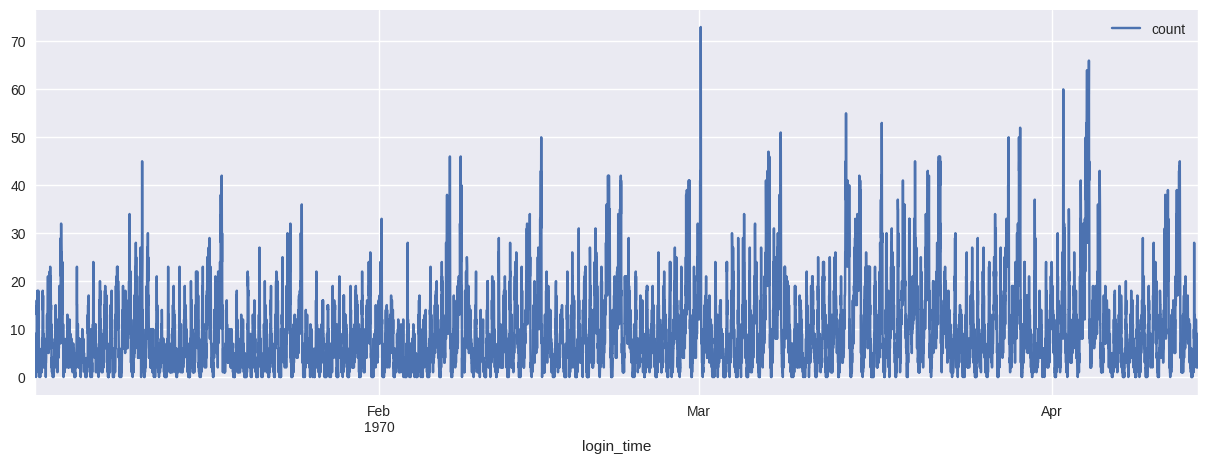

In [21]:
logins_count.plot(kind='line',figsize=(15,5))

In [23]:
logins_day = logins.resample('1D').sum()

<Axes: xlabel='login_time'>

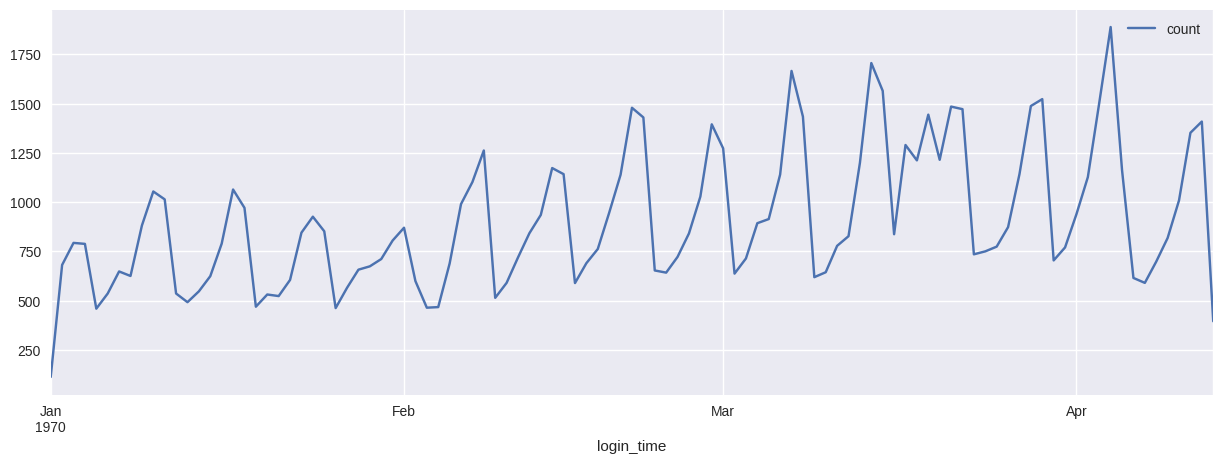

In [24]:
logins_day.plot(kind='line',figsize=(15,5))

It seems that users were not active in January, and the average daily login was stable. However, from February to April, it showed a steady increasing trend.

Text(0.5, 28.999999999999986, 'day')

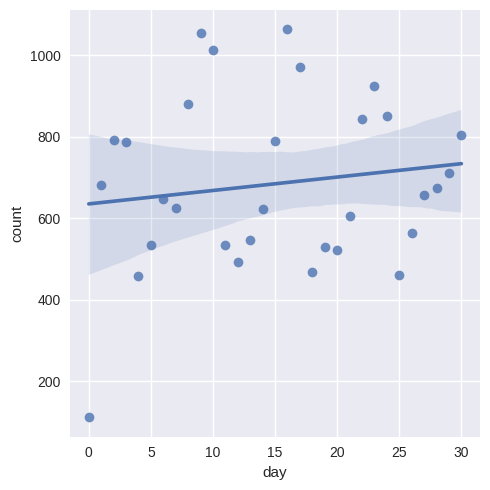

In [25]:
plot_logins = logins_day[logins_day.index.month==1]
plot_logins = plot_logins.assign(x = range(plot_logins.shape[0]))
sns.lmplot(data = plot_logins, x = 'x',y = 'count')
plt.xlabel('day')

Text(0.5, 28.999999999999986, 'day')

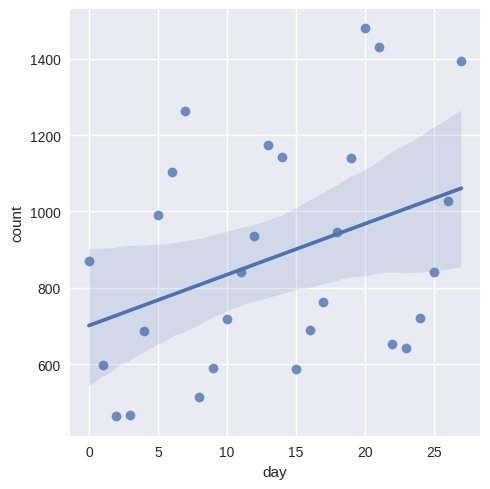

In [26]:
plot_logins = logins_day[logins_day.index.month==2]
plot_logins = plot_logins.assign(x = range(plot_logins.shape[0]))
sns.lmplot(data = plot_logins, x = 'x',y = 'count')
plt.xlabel('day')

Text(0.5, 28.999999999999986, 'day')

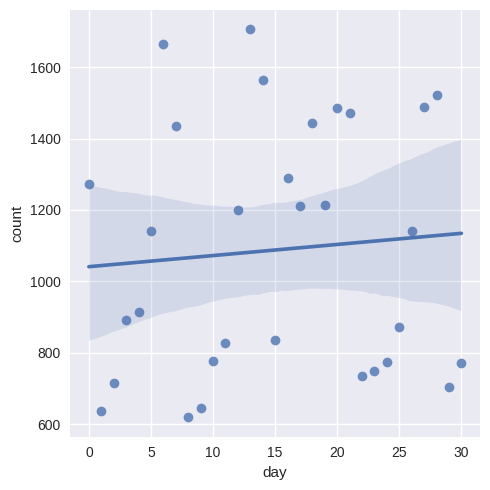

In [27]:
plot_logins = logins_day[logins_day.index.month==3]
plot_logins = plot_logins.assign(x = range(plot_logins.shape[0]))
sns.lmplot(data = plot_logins, x = 'x',y = 'count')
plt.xlabel('day')

Text(0.5, 28.999999999999986, 'day')

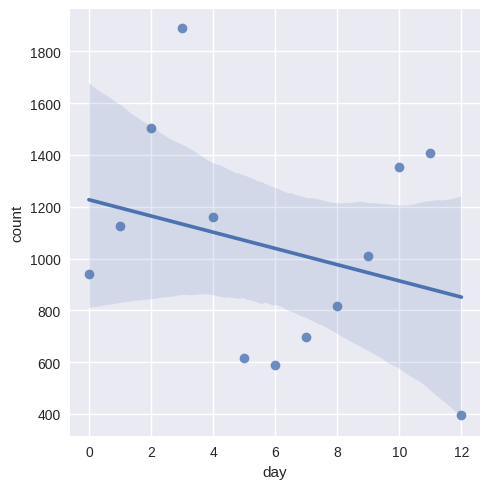

In [28]:
plot_logins = logins_day[logins_day.index.month==4]
plot_logins = plot_logins.assign(x = range(plot_logins.shape[0]))
sns.lmplot(data = plot_logins, x = 'x',y = 'count')
plt.xlabel('day')

Text(0.5, 28.999999999999986, 'day')

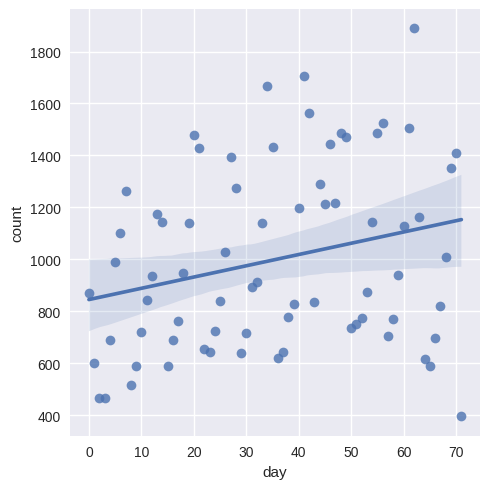

In [32]:
plot_logins = logins_day[logins_day.index.month!=1]
plot_logins = plot_logins.assign(x = range(plot_logins.shape[0]))
sns.lmplot(data = plot_logins, x = 'x',y = 'count')
plt.xlabel('day')

Above we compared the growth trends in January, February, March and April respectively. By removing the data in January, we can clearly see the growth trend from February to April.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the observation

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

***1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?***

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
Through the above conditions, I can feel that there will be reasonable activities in both cities on weekends, which shows that the data on weekends is not enough to reflect the difference in activities. So my key metric is to choose the frequency of activities during the workday. By observing the traffic flow between two cities during the weekday, two hypotheses can be formulated. Since the city of Gotham is very active at night on weekdays, I will focus on observing the density of drivers arriving at Gotham through the bridge at night on weekdays. And because the city of metropolis is generally very active during the daytime on weekdays, I will also observe the density of drivers who arrive at the city of metropolis through the bridge during the day.
Since the driver density is very easy to observe (for example, a GPS system can be embedded in the driver's mobile phone software to achieve the purpose of observing driver data through statistics), so I will choose this as my measurement standard.



***2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:***

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the observation

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Facing two different cities, I will use two hypothesis tests to compare the pre-implementation and post-implementation of the two cities respectively.
h0: The number of drivers arriving in Gotham city via the bridge during the evening hours (weekdays) recorded in the week before the reimbursement activity.
h2: Record the number of drivers arriving in Gotham city through the bridge at night time (weekdays) one week after the reimbursement campaign was implemented.
h0: the number of drivers arriving at metropolis via the bridge during daytime hours (weekdays) recorded in the week before the reimbursement activity
h2: Record the number of daytime (weekday) drivers arriving at Metropolis via the bridge during the week following the reimbursement campaign
The two-sided hypothesis and z-test were used to determine and verify the completeness of observations.
The obtained driver density data can be analyzed intuitively. If the number density of drivers increases exponentially after the implementation of reimbursement activities, it means that this reimbursement measure is very feasible. And also increased the level of activity between the two cities.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

**Data description**

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [39]:
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)
df = pd.DataFrame(data)

In [40]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [42]:
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [43]:
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [44]:
df['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [46]:
fill_val = (4.777861+5) / 2
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=fill_val)
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=4.9)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [47]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [53]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
current_date = df['last_trip_date'].max()
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

Creat dummy variables for:city,phone,ultimate_black_user. And drop no use colunms:last_trip_date,signup_date,active

In [54]:
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

In [55]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


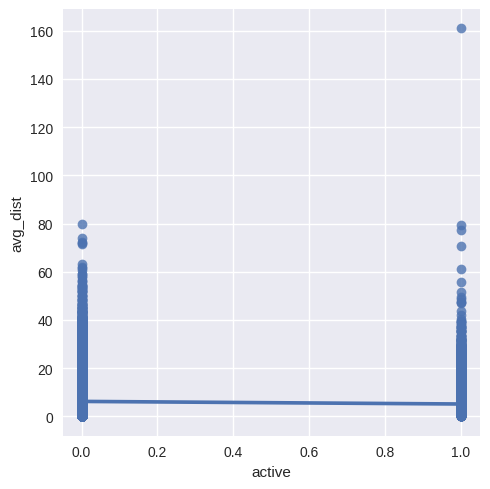

In [57]:
sns.lmplot(data=df,x='active',y='avg_dist')

In [59]:
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503901
1                       4.8  0.328753

In [60]:
pd.pivot_table(df,index='active',aggfunc={'trips_in_first_30_days':['mean','std']})

trips_in_first_30_days          
                         mean       std
active                                 
0                    1.657033  2.655767
1                    3.304804  4.985057

In [58]:
pd.pivot_table(df,index='active',aggfunc={'avg_dist':['mean','std']})

avg_dist          
            mean       std
active                    
0       6.190725  6.184010
1       5.113930  4.617779

The above reflects the difference in travel distance between active users and inactive users within 30 days. This data is very important. Through these data, the user's judgment on the driver can be made and the subsequent modeling can be influenced.

# Modeling:

In [62]:
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [64]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.7496220139098881

In [66]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.75264484 0.74899194 0.74798387 0.74899194 0.74647177]
Mean Score: 0.7516376858698302


In [65]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300634
4,weekday_pct,0.132179
6,avg_rating_by_driver,0.115484
1,avg_rating_of_driver,0.080575
0,trips_in_first_30_days,0.080571
3,surge_pct,0.076229
2,avg_surge,0.067800
8,city_King's Landing,0.047571
10,phone_Android,0.020015
11,phone_iPhone,0.019505


The established model has an accuracy rate of 75 percent. From the important characteristics of the random forest model, it can be seen that the driving distance and the driver's score account for the largest proportion. At the same time, the passenger usage density value on weekdays is also very high, but they will not become active users, and will decrease inversely. And through the comparison, it is proved that the city name and ultimate black user are not important to the overall prediction. Focus on the distance traveled by active and inactive users, as well as driver ratings.

In general, some users are encouraged to use more during weekends, and customers are encouraged to increase their trips within thirty days of registration.